In [2]:
import json
import pandas as pd
import numpy as np

from functools import reduce
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas

import YelpCleanData as cd # User Defined Fn

color = '#539ecd'

In [3]:
business = cd.open_json('data/business.json')
user = cd.open_json('data/user.json')
review = cd.open_json('data/review.json')
tip = cd.open_json('data/tip.json')

In [4]:
df_business = pd.json_normalize(business)
df_user = pd.json_normalize(user)
df_review = pd.json_normalize(review)
df_tip = pd.json_normalize(tip)

In [5]:
# Generate length of each review
df_review['review_len'] = df_review.loc[:,'text'].apply(lambda x:len(x))

In [6]:
df_business.shape, df_user.shape, df_review.shape

((150346, 60), (1987897, 22), (6990280, 10))

In [7]:
# Missing Value Imputation
# Delete Features Having high proportion of missing values
buss_missing_percent = 100 * df_business.isnull().sum() / len(df_business)
user_missing_percent = 100 * df_user.isnull().sum() / len(df_user)
review_missing_percent = 100 * df_review.isnull().sum() / len(df_review)
tip_missing_percent = 100 * df_tip.isnull().sum() / len(df_tip)

In [10]:
df_business = df_business.drop(columns=buss_missing_percent[buss_missing_percent > 20].index)
df_user = df_user.drop(columns=user_missing_percent[user_missing_percent > 20].index)
df_review = df_review.drop(columns=review_missing_percent[review_missing_percent > 20].index)
df_tip = df_tip.drop(columns=tip_missing_percent[tip_missing_percent > 20].index)

In [11]:
# Shape after deleting some features
df_business.shape, df_user.shape, df_review.shape, df_tip.shape

((150346, 16), (1987897, 22), (6990280, 10), (908915, 5))

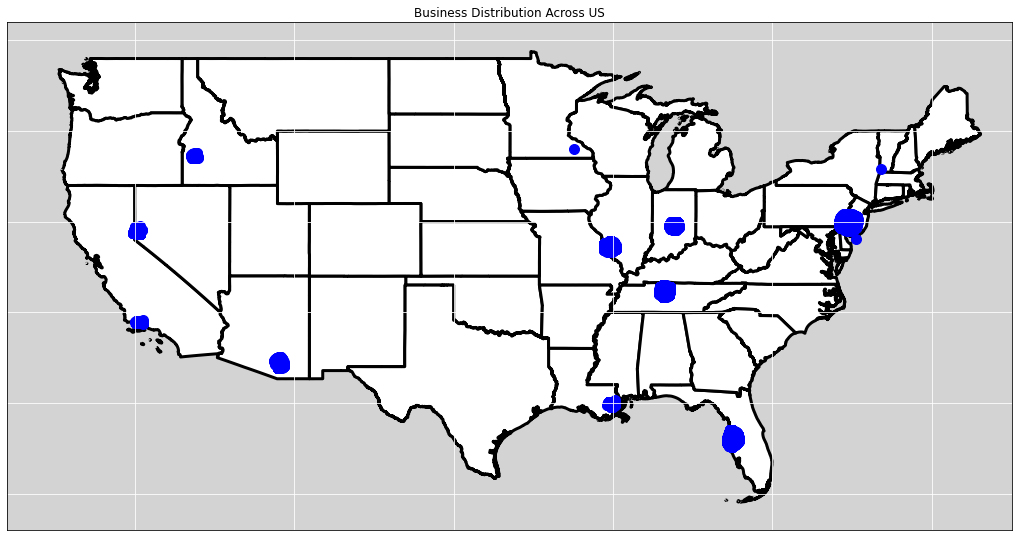

In [12]:
df = geopandas.read_file('./cb_2018_us_state_500k/cb_2018_us_state_500k.shx')
fig, continental_ax = plt.subplots(figsize=(18, 10))

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-128, -65)
continental_ax.set_ylim(23, 51)

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
ax = df.plot(ax=continental_ax, color='white', edgecolor='black', linewidth=3)
ax.set_facecolor('lightgrey')
plt.scatter(df_business.longitude, df_business.latitude, s=100, color="blue")
plt.grid(color='white')
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.title('Business Distribution Across US')
plt.savefig('Business_Distribution.jpg')
plt.show()

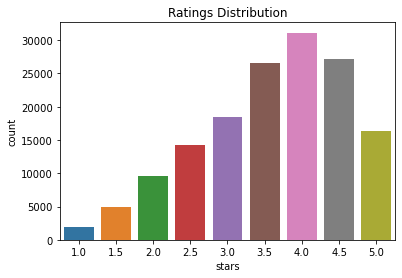

In [13]:
sns.countplot(x='stars', data=df_business)
plt.title('Ratings Distribution')
plt.savefig('Ratings_Distribution.jpg')
plt.show()

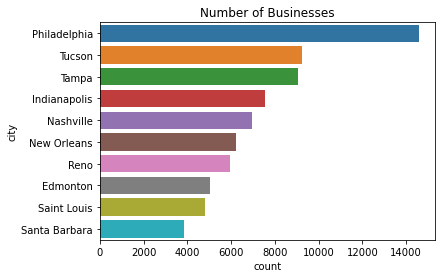

In [14]:
# Largest number of businesses with respect to city
sns.countplot(y='city', data=df_business, order=df_business['city'].value_counts().iloc[:10].index)
plt.title('Number of Businesses')
plt.show()

In [17]:
def count_cat(dic, arr):
    for cat in arr:
        cat = cat.strip()
        dic[cat] = dic.get(cat, 0) + 1
    return dic

def count_city_cat(dic, arr):
    city = arr[0]
    arr = arr[1:]
    for cat in arr:
        cat = cat.strip()
        if cat == 'Food' and 'Restaurants' not in arr:
            cat = 'Restaurants'
        key = city + ' | ' + cat
        dic[key] = dic.get(key, 0) + 1
    return dic

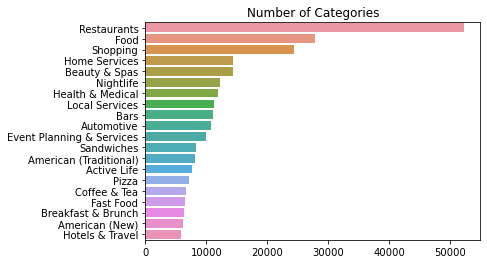

In [16]:
# Categories
cat_split = df_business['categories'].apply(lambda x: x.split(',') if x is not None else 'None')
results = reduce(count_cat, cat_split, {})

cat_ranks = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
cat_keys = list(cat_ranks.keys())[:20]
cat_vals = [float(cat_ranks[k]) for k in cat_keys]
sns.barplot(x=cat_vals, y=cat_keys)
plt.title('Number of Categories')
plt.show()

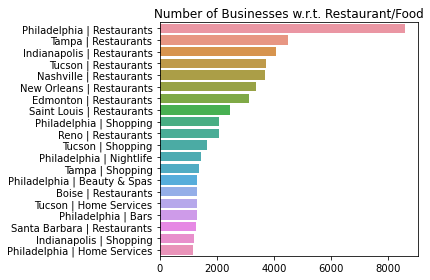

In [19]:
# Number of Businesses for each city having categories either Restaurant or Food

city_cat_split = df_business.apply(lambda x: [x['city']]+x['categories'].split(',') if x['categories'] is not None else 'None', axis=1)
results_citycat = reduce(count_city_cat, city_cat_split, {})

citycat_ranks = dict(sorted(results_citycat.items(), key=lambda x: x[1], reverse=True))
keys = list(citycat_ranks.keys())[:20]
vals = [float(citycat_ranks[k]) for k in keys]
sns.barplot(x=vals, y=keys)
plt.title('Number of Businesses w.r.t. Restaurant/Food')
plt.tight_layout()
plt.savefig('Num_Restaurants.jpg')
plt.show()

In [20]:
# Num of Restaurants/Food Businesses
df_business['IsRestaurant'] = df_business.apply(lambda x: any([True if cat.strip() in ['Food','Restaurants'] else False for cat in x['categories'].split(',')]) if x['categories'] is not None else False, axis=1)
df_business['IsRestaurant'].value_counts()

False    85769
True     64577
Name: IsRestaurant, dtype: int64

In [21]:
# Largest num of Restaurants/Food Businesses
# Filtering with the city
city = 'Philadelphia'
df_city_business = df_business.loc[(df_business['city'] == city) & df_business['IsRestaurant'] == True].reset_index(drop=True)
df_city_business = df_city_business.drop(columns=['hours.Tuesday','hours.Wednesday','hours.Thursday', 'hours.Friday'])

In [22]:
# Filtering out other Dataframes with respect to Philadelphia
df_city_review = df_review[df_review['business_id'].isin(df_city_business['business_id'].unique())].reset_index(drop=True)
df_city_user = df_user[df_user['user_id'].isin(df_city_review['user_id'].unique())].reset_index(drop=True)
df_city_tip = df_tip[df_tip['business_id'].isin(df_city_business['business_id'].unique())].reset_index(drop=True)

In [24]:
# Shape of each data frame
df_city_business.shape, df_city_review.shape, df_city_user.shape, df_city_tip.shape

((7073, 14), (738456, 10), (216803, 22), (95198, 5))

In [25]:
# elite_num, friends_num
df_city_user.loc[:,'elite'] = df_city_user.loc[:,'elite'].str.replace('20,20','2020')
df_city_user.loc[:,'friends'] = df_city_user.loc[:,'friends'].str.replace('None','')
df_city_user['elite_num'] = df_city_user.loc[:,'elite'].apply(lambda x:len(x.split(',')) if len(x)!=0 else 0)
df_city_user['friends_num'] = df_city_user.loc[:,'friends'].apply(lambda x:len(x.split(',')) if len(x)!=0 else 0)

In [26]:
# Save cleaned data
df_city_business.to_csv('data/city_business.csv', index=False)
df_city_review.to_csv('data/city_review.csv', index=False)
df_city_user.to_csv('data/city_user.csv', index=False)
df_city_tip.to_csv('data/city_tip.csv', index=False)

In [33]:
# Missing Values / NaN Counting
print('------business------')
print(df_city_business.isna().sum(axis=0)[df_city_business.isna().any(axis=0)])
print('-------review-------')
print(df_city_review.isna().sum(axis=0)[df_city_review.isna().any(axis=0)])
print('--------user--------')
print(df_city_user.isna().sum(axis=0)[df_city_user.isna().any(axis=0)])
print('--------tip---------')
print(df_city_tip.isna().sum(axis=0)[df_city_tip.isna().any(axis=0)])

------business------
Series([], dtype: int64)
-------review-------
Series([], dtype: int64)
--------user--------
Series([], dtype: int64)
--------tip---------
Series([], dtype: int64)


In [34]:
def extract_corr_over_threshold(df, threshold=0.9):
    corr = df.corr()
    upper_corr = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool_))
    return {(col1,col2):cor for col1,col2,cor in upper_corr[abs(upper_corr) > threshold].unstack().reset_index().dropna().to_numpy()}

In [37]:
# Highly Correlated Features
buss_high_corr = extract_corr_over_threshold(df_city_business)
review_high_corr = extract_corr_over_threshold(df_city_review)
user_high_corr = extract_corr_over_threshold(df_city_user)
tip_high_corr = extract_corr_over_threshold(df_city_tip)

print('------business------')
pprint(buss_high_corr)
print('-------review-------')
pprint(review_high_corr)
print('--------user--------')
pprint(user_high_corr)
print('--------tip---------')
pprint(tip_high_corr)

------business------
{}
-------review-------
{}
--------user--------
{('compliment_funny', 'compliment_cool'): 1.0,
 ('compliment_list', 'compliment_more'): 0.9363365296568943,
 ('compliment_list', 'compliment_profile'): 0.9601742704917566,
 ('compliment_photos', 'compliment_cool'): 0.9035608240866252,
 ('compliment_photos', 'compliment_funny'): 0.9035608240866252,
 ('compliment_profile', 'compliment_more'): 0.9685776849396807,
 ('compliment_writer', 'compliment_cool'): 0.9219584496241107,
 ('compliment_writer', 'compliment_funny'): 0.9219584496241107,
 ('cool', 'funny'): 0.9769971079573091,
 ('cool', 'useful'): 0.992649420729395,
 ('funny', 'useful'): 0.9641554521174106}
--------tip---------
{}


In [38]:
# Delete Highly Corr
df_city_user = df_city_user.drop('useful', axis=1)
df_city_user = df_city_user.drop('funny', axis=1)
df_city_user = df_city_user.drop('compliment_cool', axis=1)
df_city_user = df_city_user.drop('compliment_more', axis=1)
df_city_user = df_city_user.drop('compliment_profile', axis=1)
df_city_user = df_city_user.drop('compliment_funny', axis=1)

In [39]:
# Correlation With Target
print(df_city_business.corr()['stars'], '\n')
print(df_city_user.corr()['average_stars'], '\n')
print(df_city_review.corr()['stars'])

latitude       -0.121202
longitude      -0.043069
stars           1.000000
review_count    0.129721
is_open         0.024363
IsRestaurant         NaN
Name: stars, dtype: float64 

review_count         0.034974
cool                 0.010085
fans                 0.016384
average_stars        1.000000
compliment_hot       0.006039
compliment_cute      0.004681
compliment_list      0.002833
compliment_note      0.003532
compliment_plain     0.006310
compliment_writer    0.007572
compliment_photos    0.004658
elite_num            0.053370
friends_num          0.053355
Name: average_stars, dtype: float64 

stars         1.000000
useful       -0.033583
funny        -0.057348
cool          0.072094
review_len   -0.125442
Name: stars, dtype: float64


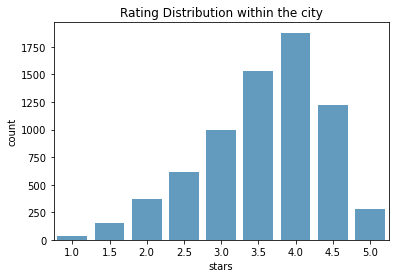

In [41]:
# Rating Distribution within the city
sns.countplot(x='stars', data=df_city_business, color=color)
plt.title('Rating Distribution within the city')
plt.show()

In [42]:
# Obvious Relationship
df_city_user.corr().loc['elite_num','review_count']

0.6770230431966023

In [4]:
# Review Count within the city
city_agg = df_city_review.groupby('user_id').agg({'review_id':'count', 'stars':'mean'})
city_agg = city_agg.rename(columns={'review_id':'city_review_count','stars':'city_avg_stars'})

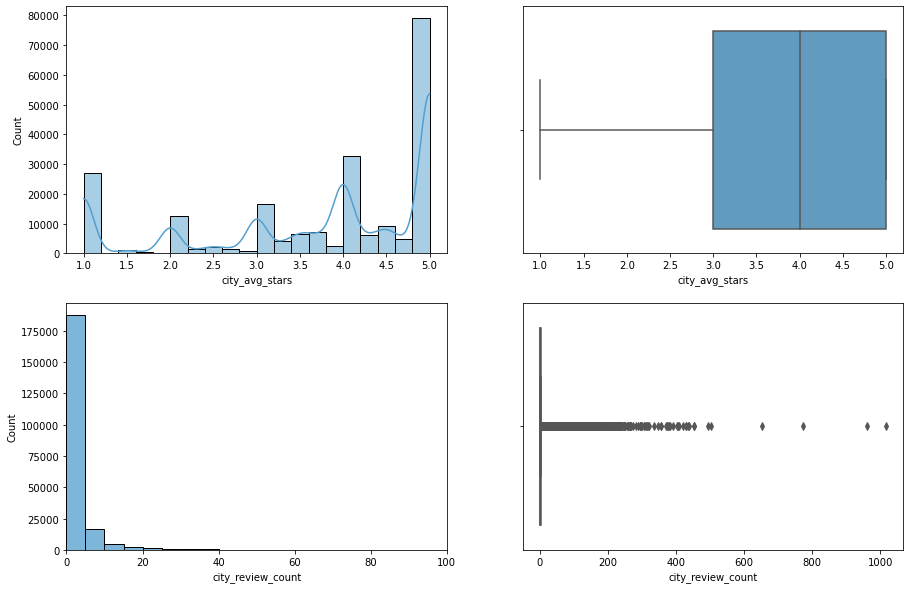

In [5]:
# Various Plots
fig, axes = plt.subplots(2,2, figsize=(15, 10))
sns.histplot(city_agg['city_avg_stars'], bins=20, kde=True, ax=axes[0,0], color=color)
sns.boxplot(x=city_agg["city_avg_stars"], ax=axes[0,1], color=color)

sns.histplot(city_agg['city_review_count'], bins=np.linspace(0,100,21), ax=axes[1,0], color=color)
sns.boxplot(x=city_agg["city_review_count"], ax=axes[1,1], color=color)
axes[1,0].set_xlim(0, 100)

plt.show()

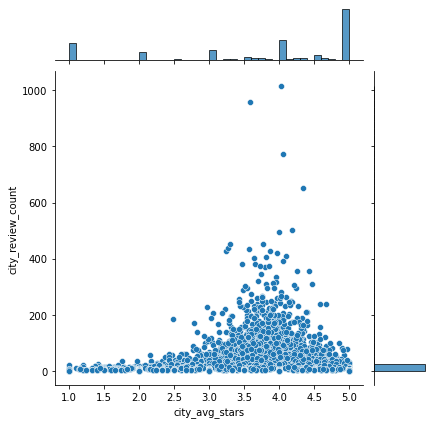

In [6]:
fig = sns.jointplot(x='city_avg_stars', y='city_review_count', data=city_agg, marginal_kws=dict(bins=40))
# plt.title('Review vs Avg. Stars', x=-3.0, y=-0.2)
# plt.savefig('Review_Avg_Stars.jpg')
plt.show()

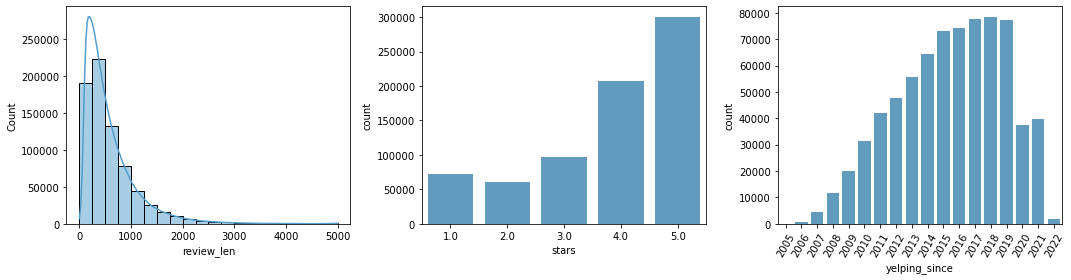

In [9]:
fig, axes = plt.subplots(1,3, figsize=(15, 4))
sns.histplot(df_city_review['review_len'], bins=20, kde=True, ax=axes[0], color=color)
sns.countplot(x=df_city_review['stars'], ax=axes[1], color=color)
sns.countplot(x=pd.to_datetime(df_city_review['date']).dt.year, ax=axes[2], color=color)
axes[2].set(xlabel='yelping_since')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=60)
fig.tight_layout()
plt.savefig('city_plots.jpg')
plt.show()

In [3]:
# df_city_business = pd.read_csv('data/city_business.csv')
# df_city_review = pd.read_csv('data/city_review.csv')
# df_city_user = pd.read_csv('data/city_user.csv')
# df_city_tip = pd.read_csv('data/city_tip.csv')